In [29]:
import osmnx as ox
import networkx as nx
import numpy as np
import random
from matplotlib import pyplot as plt

In [49]:
graph = ox.load_graphml("../india_highways.graphml")
# graph = ox.convert.to_undirected(graph)

In [53]:
G = nx.DiGraph(graph)
source = list(G.nodes())[3]

In [54]:
connected_components = nx.number_weakly_connected_components(G)
print(connected_components)

34


In [57]:
start_node = source
start_node = 2290795717
max_depth = 200

layers = {}
visited = set()
queue = [(source, 0)]  # (node, layer)

while queue:
    node, layer = queue.pop(0)
    if node in visited:
        continue
    visited.add(node)

    # Add the node to its corresponding layer
    if layer not in layers:
        layers[layer] = []
    layers[layer].append(node)

    # Add neighbors to the queue for the next layer
    for neighbor in graph.neighbors(node):
        if neighbor not in visited:
            queue.append((neighbor, layer + 1))
            
for layer in layers.keys():
    print(f"{layer}: {layers[layer]}")

0: [1705557606]
1: [1705557609]
2: [8118751128, 1705557619]
3: [4771639867, 3833705188, 1705557616]
4: [1880655543, 1288165301, 1705557634, 1705557612]
5: [299270146, 1444103394, 1794814265, 8118723067]
6: [2787298132, 1794821119, 1794814298, 8118723068]
7: [1794821112, 299713642, 2419037756, 8118723057]
8: [5157095793, 2419037753, 299669428, 8118723045]
9: [8118723069, 8118723077, 8118751132]
10: [8118723078]
11: [8118723086, 8118723041]
12: [8118723030]


In [58]:
all_walk = []  # To store all unique walks
unique_walks = set()  # To track unique walks
n = 50000  # Number of times to run the random walk

for _ in range(n):
    # Reset the walk for each run
    walk = [start_node]
    current_layer = 0
    
    while current_layer < max_depth:
        current_node = walk[-1]
        next_layer = current_layer + 1

        # Get valid neighbors in the next layer
        valid_next_nodes = [
            node for node in layers.get(next_layer, [])
            if node in G.neighbors(current_node) and node not in walk
        ]

        # If no valid next nodes, break
        if not valid_next_nodes:
            break

        # Randomly select the next node
        next_node = np.random.choice(valid_next_nodes)
        walk.append(next_node)
        current_layer += 1

    # Convert walk to tuple for hashing and check uniqueness
    walk_tuple = tuple(walk)
    if walk_tuple in unique_walks:
        continue  # Skip duplicate walks

    # Add walk to the set of unique paths
    unique_walks.add(walk_tuple)

    # Calculate the length of the route only for unique walks
    route = ox.routing.route_to_gdf(graph, walk)
    route = route.to_crs(epsg=4326)
    route_length = sum(route['length'])

    # Save the walk and its length
    all_walk.append({
        "route": walk,
        "route_length": route_length
    })


ValueError: Graph contains no edges.

In [56]:
print(len(all_walk))

78


In [46]:
path_lengths = {
    'small': (10000, 20000),
    'medium': (20000, 80000),
    'large': (80000, 250000),
    'XL': (250000, 750000)
}

num_samples = 5

In [47]:
categorized_paths = {category: [] for category in path_lengths}

# Categorize paths
for walk in all_walk:
    for category, (min_length, max_length) in path_lengths.items():
        if min_length <= walk["route_length"] <= max_length:
            categorized_paths[category].append(walk)

# Select random samples from each category
selected_paths = {}
for category, paths in categorized_paths.items():
    selected_paths[category] = random.sample(paths, min(len(paths), num_samples))

In [48]:
for category, paths in selected_paths.items():
    print(f"{category.capitalize()} paths:")
    for path in paths:
        print(f"  - {path['route']} ({path['route_length']} km)")
    print()

Small paths:
  - [349126490, 9939289665, 1519122647, 6227305413, 6030018628, 6030018629, 6030018677, 9579857815, 9579857810] (11117.569982007097 km)
  - [349126490, 9939289665, 1519122647, 6227305413, 6030018628, 6030018629, 6030018677, 452017426, 452017371] (15089.206223907511 km)
  - [349126490, 9939289665, 1519122647, 6227305413, 6030018628, 6030018629, 6030018792, 5132776887, 5132776883] (15950.47645059133 km)
  - [349126490, 9939289665, 1519122647, 6227305413, 6030018628, 6030018629, 6030018677, 452017426, 1207067950] (17624.10154711795 km)

Medium paths:
  - [349126490, 9939289665, 1519122647, 6227305413, 6030018628, 6030018629, 6030018677, 452017426, 2211563011, 2211572327] (51420.74766408036 km)
  - [349126490, 9939289665, 1519122647, 6227305413, 6030018628, 1185821004, 1519122650, 11542200064, 9939289658, 1185820929, 2314649604, 2290795745, 2290795733, 2290795728, 2290795748, 1185821132, 1519122460] (43388.30387552747 km)
  - [349126490, 9939289665, 1519122647, 6227305413, 603

In [31]:
walk = longest_walk

In [16]:
for node in walk:
    if node not in G.nodes:
        print(f"Invalid node in path: {node}")

print(len(walk))
print(len(set(walk)))

31
31


In [17]:
from networkx.algorithms.components import is_connected, connected_components

sub_graph = graph.subgraph(walk)
sub_graph = ox.convert.to_undirected(sub_graph)
print(is_connected(sub_graph))

True


87939.35587409587


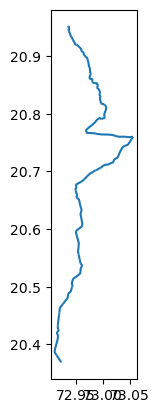

In [18]:
# fig,ax = ox.plot.plot_graph(sub_graph, edge_color='blue', node_color='red', node_size=50, edge_linewidth=3)
route = ox.routing.route_to_gdf(graph,walk)
route = route.to_crs(epsg=4326)
route.plot()
print(sum(route['length']))
# ox.plot_graph_route(sub_graph, walk, route_color='yellow')
plt.show()